In [9]:
# %% [markdown]
# # Spotify Popularity - Neural Network (TensorFlow + KerasTuner)

# %%
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Eğer yüklü değilse bir defaya mahsus:
# !pip install keras-tuner
#!pip install keras_tuner
import keras_tuner as kt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [10]:
# %%
df = pd.read_csv("scaled_data.csv")
df["popularity"] = np.log(df['popularity'] + 1)
 
print(df.head())
print(df.shape)


   popularity  danceability  energy  loudness  mode  speechiness  \
0    4.204693         0.748   0.916  0.918090     1       0.0583   
1    4.219508         0.726   0.815  0.869162     1       0.0373   
2    4.262680         0.675   0.931  0.901368     0       0.0742   
3    4.110874         0.718   0.930  0.894118     1       0.1020   
4    4.248495         0.650   0.833  0.875385     1       0.0359   

   acousticness  instrumentalness  liveness  valence  ...  key_2  key_3  \
0        0.1020          0.000000    0.0653    0.518  ...      0      0   
1        0.0724          0.004210    0.3570    0.693  ...      0      0   
2        0.0794          0.000023    0.1100    0.613  ...      0      0   
3        0.0287          0.000009    0.2040    0.277  ...      0      0   
4        0.0803          0.000000    0.0833    0.725  ...      0      0   

   key_4  key_5  key_6  key_7  key_8  key_9  key_10  key_11  
0      0      0      1      0      0      0       0       0  
1      0      0 

In [11]:
# %%
target_col = "popularity"  # burada kendi target adını kullan

X = df.drop(columns=[target_col])
y = df[target_col]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (28356, 57)
Target shape: (28356,)


In [12]:
# %%
# önce train+temp, sonra temp'i val+test olarak ayırıyoruz
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)


Train: (19849, 57) (19849,)
Val: (4253, 57) (4253,)
Test: (4254, 57) (4254,)


In [14]:
# %%
# Önce veri tiplerini kontrol edelim
print("Data types:")
print(X_train.dtypes)
print("\nNon-numeric columns:")
non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric)

# Eğer non-numeric kolonlar varsa onları çıkar
if non_numeric:
    print(f"\nRemoving non-numeric columns: {non_numeric}")
    X_train = X_train.select_dtypes(include=[np.number])
    X_val = X_val.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])

X_train_np = X_train.to_numpy().astype("float32")
X_val_np   = X_val.to_numpy().astype("float32")
X_test_np  = X_test.to_numpy().astype("float32")

y_train_np = y_train.to_numpy().astype("float32")
y_val_np   = y_val.to_numpy().astype("float32")
y_test_np  = y_test.to_numpy().astype("float32")

input_dim = X_train_np.shape[1]
print("\nInput dim:", input_dim)
print("Train shape:", X_train_np.shape)

Data types:
danceability                          float64
energy                                float64
loudness                              float64
mode                                    int64
speechiness                           float64
acousticness                          float64
instrumentalness                      float64
liveness                              float64
valence                               float64
tempo                                 float64
duration_ms                           float64
playlist_count                        float64
genre_edm                               int64
genre_latin                             int64
genre_pop                               int64
genre_r&b                               int64
genre_rap                               int64
genre_rock                              int64
subgenre_album rock                     int64
subgenre_big room                       int64
subgenre_classic rock                   int64
subgenre_dance pop    

In [15]:
# %%
def build_model(hp: kt.HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # kaç tane hidden layer
    n_layers = hp.Int("n_layers", min_value=1, max_value=4)

    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.BatchNormalization())
        dropout_rate = hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.5, step=0.1)
        model.add(layers.Dropout(dropout_rate))

    # output layer (regression → 1 nöron)
    model.add(layers.Dense(1, activation="linear"))

    # learning rate
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [16]:
# %%
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=25,           # istersen 40-50'ye çıkar ama süre uzar
    directory="nn_tuner_logs",
    project_name="spotify_popularity_nn"
)

tuner.search_space_summary()


Search space summary
Default search space size: 4
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [17]:
# %%
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

tuner.search(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=200,
    batch_size=32,           # istersen bunu da hp'ye açabiliriz
    callbacks=[early_stop],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)


Trial 25 Complete [00h 00m 51s]
val_loss: 0.7894162535667419

Best val_loss So Far: 0.7769914269447327
Total elapsed time: 00h 23m 26s
Best hyperparameters: {'n_layers': 1, 'units_0': 64, 'dropout_0': 0.5, 'learning_rate': 0.0007066348200724681, 'units_1': 32, 'dropout_1': 0.1, 'units_2': 96, 'dropout_2': 0.2, 'units_3': 128, 'dropout_3': 0.5}


In [18]:
# %%
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3441 - mae: 1.8501 - val_loss: 1.0868 - val_mae: 0.7920
Epoch 2/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3441 - mae: 1.8501 - val_loss: 1.0868 - val_mae: 0.7920
Epoch 2/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6669 - mae: 1.0106 - val_loss: 0.9635 - val_mae: 0.6961
Epoch 3/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6669 - mae: 1.0106 - val_loss: 0.9635 - val_mae: 0.6961
Epoch 3/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3609 - mae: 0.9011 - val_loss: 0.9177 - val_mae: 0.6640
Epoch 4/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3609 - mae: 0.9011 - val_loss: 0.9177 - val_mae: 0.6640
Epoch 4/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2397 - mae: 0.8473 - val_loss: 0.8806 - val_mae: 0.6479
Epoch 5/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2397 - mae: 0.8473 - val_loss: 0.8806 - val_mae: 0.6479
Epoch 5/200
621/621 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

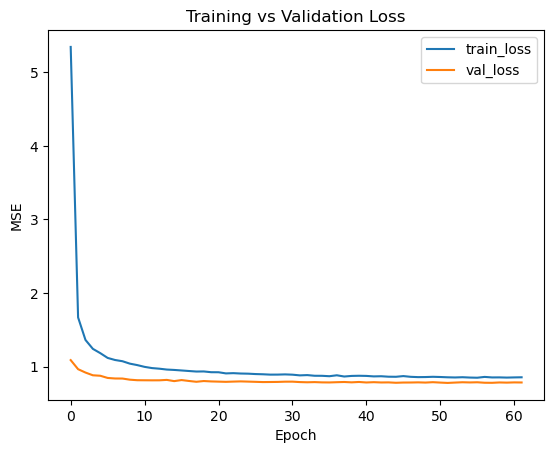

In [19]:
# %%
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [23]:
# %%
y_pred_test_log = best_model.predict(X_test_np).ravel()

# Log-transformed metrikleri
mae_log  = mean_absolute_error(y_test_np, y_pred_test_log)
mse_log  = mean_squared_error(y_test_np, y_pred_test_log)
rmse_log = np.sqrt(mse_log)
r2_log   = r2_score(y_test_np, y_pred_test_log)

print("=== Log-Transformed Metrikleri ===")
print(f"Test MAE : {mae_log:.4f}")
print(f"Test RMSE: {rmse_log:.4f}")
print(f"Test R²  : {r2_log:.4f}")

# Orijinal ölçeğe çevir
y_pred_test_original = np.expm1(y_pred_test_log)
y_test_original = np.expm1(y_test_np)

# Tahminleri 0-100 aralığına sınırlandır (popularity 0-100 arası olmalı)
y_pred_test_clipped = np.clip(y_pred_test_original, 0, 100)

print(f"\nTahmin istatistikleri:")
print(f"Min: {y_pred_test_original.min():.2f}, Max: {y_pred_test_original.max():.2f}")
print(f"100'ü aşan tahmin sayısı: {(y_pred_test_original > 100).sum()}")
print(f"0'ın altında tahmin sayısı: {(y_pred_test_original < 0).sum()}")

# Orijinal ölçekteki metrikler (clipped değerlerle)
mae_original  = mean_absolute_error(y_test_original, y_pred_test_original)
mse_original  = mean_squared_error(y_test_original, y_pred_test_original)
rmse_original = np.sqrt(mse_original)
r2_original   = r2_score(y_test_original, y_pred_test_original)

print("\n===originalal Ölçekte Metrikler ===")
print(f"Test MAE : {mae_original:.2f}")
print(f"Test RMSE: {rmse_original:.2f}")
print(f"Test MSE : {mse_original:.2f}")
print(f"Test R²  : {r2_original:.4f}")

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
=== Log-Transformed Metrikleri ===
Test MAE : 0.5737
Test RMSE: 0.8995
Test R²  : 0.5424

Tahmin istatistikleri:
Min: -0.59, Max: 205.01
100'ü aşan tahmin sayısı: 11
0'ın altında tahmin sayısı: 32

===originalal Ölçekte Metrikler ===
Test MAE : 13.30
Test RMSE: 18.27
Test MSE : 333.94
Test R²  : 0.4192
=== Log-Transformed Metrikleri ===
Test MAE : 0.5737
Test RMSE: 0.8995
Test R²  : 0.5424

Tahmin istatistikleri:
Min: -0.59, Max: 205.01
100'ü aşan tahmin sayısı: 11
0'ın altında tahmin sayısı: 32

===originalal Ölçekte Metrikler ===
Test MAE : 13.30
Test RMSE: 18.27
Test MSE : 333.94
Test R²  : 0.4192


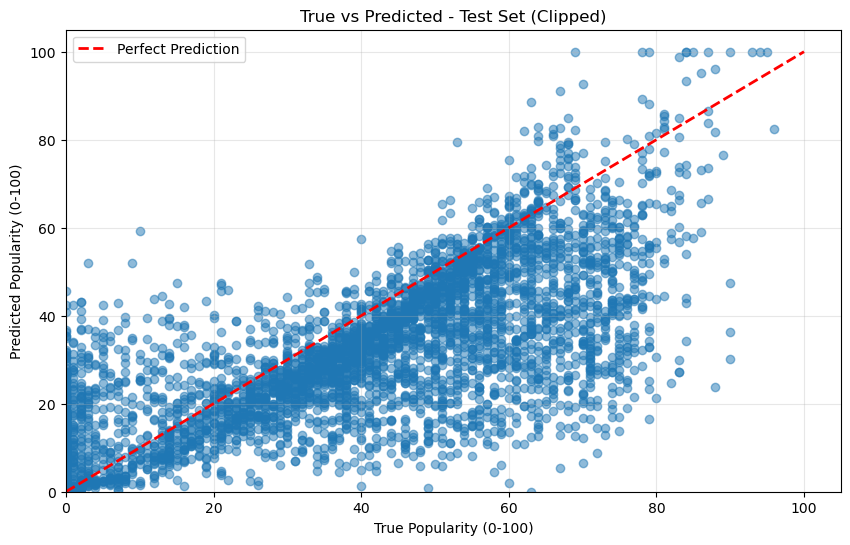

In [24]:
# %%
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_test_clipped, alpha=0.5)
plt.xlabel("True Popularity (0-100)")
plt.ylabel("Predicted Popularity (0-100)")
plt.title("True vs Predicted - Test Set (Clipped)")
# y=x referans çizgisi
plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
plt.xlim([0, 105])
plt.ylim([0, 105])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# %%
best_model.save("best_nn_spotify.keras")


In [ ]:
# %%
best_model.save("best_nn_spotify.h5")
